<a href="https://colab.research.google.com/github/avirmani2024/NLP-Project-/blob/master/Aditya_Virmani_lp_Review_Sentiment_Classification_Using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yelp Review Sentiment Classification Project Using NLP

In this project, I will build a classifier that can predict how a user feels (positively or negatively) about a given restaurant from their review. This is an example of **sentiment analysis**: being able to quantify an individual's opinion about a particular topic merely from the words they use.


In this notebook, we'll:


*   Explore the Yelp review dataset
*   Preprocess and vectorize our text data for NLP
*   Train a sentiment analysis classifier with logistic regression
*    Explore and improve our model
*   Train a model with word embeddings


Let's dive in!




In [4]:
#@title Import our libraries (this may take a minute or two)
import pandas as pd   # Great for tables (google spreadsheets, microsoft excel, csv).
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import wordcloud
import os # Good for navigating your computer's files
import sys
pd.options.mode.chained_assignment = None #suppress warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python -m spacy download en_core_web_md
import en_core_web_md
text_to_nlp = spacy.load('en_core_web_md')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2023-07-12 19:52:38.699818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [5]:
#@title Import our data

!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket/yelp_final.csv"

# If you run into any errors please uncomment and load the dataset below:

##!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv"


yelp_final.csv      100%[===================>] 526.75K  --.-KB/s    in 0.007s  


# Data Exploration

First we read in the file containing the reviews and take a look at the data available to us.

In [6]:
# read our data in using 'pd.read_csv('file')'
yelp_full = pd.read_csv('yelp_final.csv')
yelp_full.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


In [7]:
needed_columns = ['stars','text']
yelp = yelp_full[needed_columns]
yelp.head()

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
3,5,General Manager Scott Petello is a good egg!!!...
4,5,Drop what you're doing and drive here. After I...


The text column is the one we are primarily focused with. Let's take a look at a few of these reviews to better understand our problem.

In [8]:
#@title Check out the text in differently rated reviews
num_stars =  1#@param {type:"integer"}

for t in yelp[yelp['stars'] == num_stars]['text'].head(20).values:
    print (t)

Disgusting!  Had a Groupon so my daughter and I tried it out.  Very outdated and gaudy 80's style interior made me feel like I was in an episode of Sopranos.  The food itself was pretty bad.  We ordered pretty simple dishes but they just had no flavor at all!  After trying it out I'm positive all the good reviews on here are employees or owners creating them.
Not busy at all but took nearly 45 min to get our meal.  Ordered the trout and was shocked to see lots and lots of bones. Hmmmmm. Well asked the waitress about it and she said "they try the best they can"  hmmmmmm isn't this a "fish" restaurant? 
They comped the trout but still not sure I would go back.
Yikes, reading other reviews I realize my bad experience wasn't unique. As a server I make a very laid back customer. I like pretty much everything I eat and don't require a lot of attention from the waiter. 

La Piccola Cucina would benefit from just one extra person in the front of the house. Our guy, though adorable and friendly

#### Word Clouds

Another way to take a look at the most prominent words in any given star rating is through the use of word clouds.

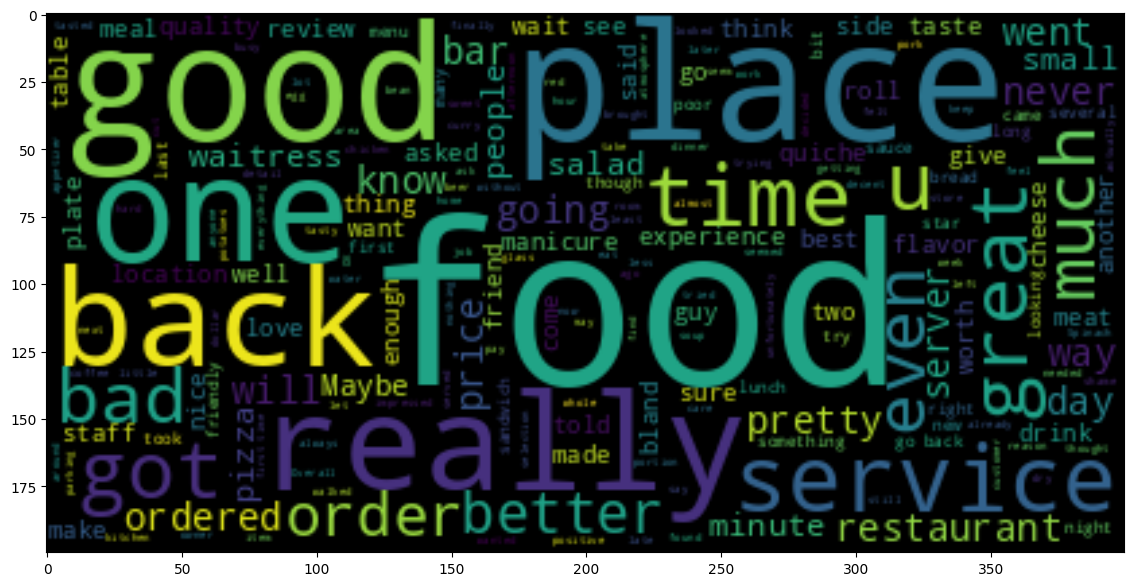

In [9]:
#@title Word cloud for differently rated reviews
num_stars =  2#@param {type:"integer"}
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '

wordcloud = WordCloud()
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

**What are the differences between the reviews that have 1, 2, 3, 4, and 5 stars?**

Any surprising similarities?


# Preparing Our Data for Machine Learning

Of course, it's much more efficient to use machine learning to analyze our text than try to create rules by hand!

We'll need to prepare our data to use logistic regression. First, let's prepare our output column:

### Exercise: Preparing to Classify
We're going to try to predict the sentiment - **positive** or **negative** - based on a review's text.

In order to reduce our problem to a **binary classification** (two classes) problem, we will:

 - label 4 and 5 star reviews as 'good'
 - label 1, 2, 3 star reviews as 'bad'

Please complete the function below and run it to create a new `is_good_review` column!

In [10]:
def is_good_review(num_stars):
    if num_stars > 3: ### YOUR CODE HERE
        return True
    else:
        return False

yelp['is_good_review'] = yelp['stars'].apply(is_good_review)
yelp.head()

,stars,text,is_good_review
0,5,My wife took me here on my birthday for breakf...,True
1,5,I have no idea why some people give bad review...,True
2,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",True
3,5,General Manager Scott Petello is a good egg!!!...,True
4,5,Drop what you're doing and drive here. After I...,True


## Text Preprocessing: A Preview

Now, the trickier part: preparing our text input.

We'll need a few steps to preprocess our text and represent it numerically. **Why do we need to represent our text as numbers?**

We'll talk through all the steps here, then use a single function to implement them.

## Tokenization

First of all, we would like to **tokenize** each review: convert it from a single string into a list of words. Enter some example text into the cell below to see the tokenized version.

In [11]:
#@title Basic tokenization example
example_text = "All the people I spoke to were super nice and very welcoming." #@param {type:"string"}
tokens = word_tokenize(example_text)
tokens

['All',
 'the',
 'people',
 'I',
 'spoke',
 'to',
 'were',
 'super',
 'nice',
 'and',
 'very',
 'welcoming',
 '.']

## Stopwords

Next, let's remove **stopwords**: words which are there to provide grammatical structure, but don't give us much information about a review's sentiment.

Edit the cell below to see if we're considering a given word as a stopword! Do you agree with the results?

In [12]:
#@title Check if a word is a stop word
example_word = "fifteen" #@param {type:'string'}
if example_word.lower() in STOP_WORDS:
  print ('"' + example_word + '" is a stop word.')
else:
  print ('"' + example_word + '" is NOT a stop word.')

"fifteen" is a stop word.


We're going to remove these stopwords from the user reviews.

Tokenization and removal of stop words are universal to nearly every NLP application. In some cases, additional cleaning may be required (for example, removal of proper nouns, removal of digits) but we can build a text preprocessing function with these "base" cleaning steps.

Putting all these together, we can come up with a text cleaning function that we can apply to all of our reviews.

## Vectors

Finally, we'll need to convert our text to **vectors**, or lists of numbers. We'll start off doing this with Bag of Words, but we'll talk about another approach later!


### Bag of Words

In a **bag of words** approach, we count how many times each word was used in each review.

Suppose we want to represent two **reviews**:
- "The food was great. The ambience was also great."
- "Great ambience, but not great food!"

First we define our vocabulary. This is *each unique word* in the review. So our **vocabulary** is:
- [also, ambience, but, food, great, not, the, was].

Next, we count up how many times each word was used! (You can also think of this as adding up one-hot encodings.)

Our reviews are encoded as:
- **First review:** [1, 1, 0, 1, 2, 0, 2, 2].
- **Second review:** [0, 1, 1, 1, 2, 1, 0, 0]



## Preprocessing Our Text in Action

Let's use bag-of-words to prepare our data!

First, let's select our input *X* and output *y*:

In [13]:
X_text = yelp['text']
y = yelp['is_good_review']

Now, let's prepare our data! First, we'll use CountVectorizer, a useful tool from Scikit-learn, to:
*   Tokenize our reviews
*   Remove stopwords
*   Prepare our vocabulary


In [14]:
#@title Initialize the text cleaning function { display-mode: "form" }
def tokenize(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these
            clean_tokens.append(token.lemma_)
    return clean_tokens


The cell below will take a moment! **Can you guess what `max_features` is for?**


In [ ]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=800).fit(X_text)

Now, we can see our entire vocabulary! Can you guess what the numbers represent?

In [ ]:
bow_transformer.vocabulary_

The number represents the **index** (alphabetical position) of a word in the vocabulary.

By the way, how many words do we have?


In [ ]:
len(bow_transformer.vocabulary_)

It's the same as `max_features`! Is that a coincidence? What's the point of `max_features`?

Now that our vocabulary is ready, we can **transform** each review into a bag of words.



In [ ]:
X = bow_transformer.transform(X_text)

Finally, we've converted our reviews to numerical data that we can use in a logistic regression!

We can see what `X` looks like by printing it out as a DataFrame. **How long is each review's vector?** Why?

In [ ]:
pd.DataFrame(X.toarray())

# Creating a Baseline Classifier

Now, back to our sentiment analysis problem! Our data is ready for machine learning.

Our classification problem is a classic two-class classification problem, and so we will use the tried-and-tested **Logistic Regression** machine learning model.

As always, we'll start by setting aside testing and training data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

###Training The Model
Now, we can create and train our model! Please **fill in the code to train (or *fit*) your model**.

(Need a hint? Refer to last time's notebook or Scikit-learn documentation if needed.)

In [ ]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)


###Testing The Model
Now, let's evaluate our model's accuracy! Your model needs to **predict** the sentiment, and then you'll **calculate the accuracy** using `accuracy_score`. **Which dataset** should you use?

In [ ]:
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print (accuracy)

Model has been trained and tested! It's not perfect, but a whole lot better than a coin flip :)


###Trying Out The Reviews

Accuracy only tells us so much! It's often useful to figure out **what sorts** of mistakes your model makes.







In [ ]:
#@title Entering a review to see the model's classification
example_review = "This restaurant is great" #@param {type:'string'}
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



# Exploring The Model

Let's explore your model in more depth.

###Viewing the Model Weights
Now let's look at the weights of our model! Remember that logistic regression works by multiplying all of our inputs by weights, summing the results, and then converting that raw number to a probability score (between 0 and 1)! This means that we can look at the weight assigned to each input (or in our case word) to figure out how that word impacts our model!



<img src='https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/Linear_logistic_regression.jpg' >

A dictionary is a data structure that stores information in key:value pairs. You retrieve the value of a given key from a dictionary dict by calling "dict[key]" which returns value. Similary, you can assign a value to a key by calling "dict[key]=value".<br><br> In the case of NLP, we need to store our vocabulary in a dictionary, where the key is the word in string format and the value is the index of that word. So, to find the index of a word in our vocab dictionary we would call "vocab[word]", which would then return the index. Similarly, we can assign a word an index by calling "vocab[word]=index".

Finishing the function, It takes in the following:

* `word`: a word from our vocabulary
* `model`: the logistic regression model whose weights we want to query.
* `vocab_dict`: a dictionary containg word:index as the key:value pair.



The function should then return the weight that the logistic regression model has learned for the word in question. The model weights (also called coefficients) can be accessed by calling `model.coef_[0][id]`, where `id` is the index of the vocab word in question.)



In [ ]:
def get_word_weight(word,model,vocab_dict):


  if word in vocab_dict:

    index=vocab_dict[word]
    weight=model.coef_[0][index]

    return weight
  else:
    return "That word is not in our Vocabulary!"

In [ ]:
#@title Input a sentence to see the weights of each word!
sentence = "this is a good place" #@param {type:'string'}
words=tokenize(sentence)
temp_weight_dict={}
for word in words:
  weight=get_word_weight(word,logistic_model,bow_transformer.vocabulary_)
  temp_weight_dict[word]=weight
print(temp_weight_dict,"bias:  "+str(logistic_model.intercept_[0]))
